# Libraries

In [ ]:
# install necessary libraries
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

In [1]:
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm
import random

# Dataset and Preprocessing

In [2]:
# function for getting the images and labels
def get_images_and_labels(dataset_path, image_size= (32,32)):
  images = []
  labels = []
  for animal in os.listdir(dataset_path): #iterate through the dicrectories inside the path
      labels.append(animal) #add the directory name as animal name to the labels list
      animal_path = os.path.join(dataset_path, animal) #get the path of the animals directory
      for img_filename in tqdm.tqdm(os.listdir(animal_path)): #iterate through the images inside the animal directory
        img_path = os.path.join(animal_path, img_filename) #get the path of the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # reads image in grayscale
        img = cv2.resize(img, image_size) #resize the images to 32x32
        images.append([img, labels.index(animal)]) # creats a list of image and its label.
  random.shuffle(images) #shuffle the images
  return images

In [3]:
# function for shuffle the images and create folds
def create_folds(images, fold_value):
  fold_size = len(images) // fold_value #size of each fold
  folds = [images[i * fold_size: (i+1) * fold_size] for i in range(fold_value)] #k1, ... ,k5 = images[0:600], ..., images[2400:3000]; folds = [k1, ... , k5]
  return folds

# Model Building

In [4]:
#function for calculating l1 and l2 distance
def calculate_l1_l2(folds):
  fold_distances_l1={i+1: [] for i in range(len(folds))} #empty dictionary where key value is the no. of fold
  fold_distances_l2={i+1: [] for i in range(len(folds))}
  for idx in range(len(folds)): #iterate through the folds
    train = []
    for i in range(len(folds)):
      if i != idx:
        train += folds[i] # 4 folds for traning
      test = folds[idx] # 1 fold for testing

    for test_img in tqdm.tqdm(test): #iterate through the test images
      l1 = []
      l2 = []
      for train_img in train:
        l1.append([np.sum(np.abs(test_img[0] - train_img[0])), train_img[1]]) #l1 = [[distance, label],.....]; 2400 distance for 1 test image
        l2.append([np.sqrt(np.sum((test_img[0] - train_img[0]) ** 2)), train_img[1]])

      l1.sort(key=lambda x: x[0]) # sort the list according to distance(inner list's 0 index); [[sorting index or distance, label],[],[],......]
      l2.sort(key=lambda x: x[0])
      fold_distances_l1[idx+1].append(l1) # fold_disttances_l1[fold index][l1];
      fold_distances_l2[idx+1].append(l2)
  return fold_distances_l1, fold_distances_l2

In [5]:
def get_accuracies(folds, fold_distances, k_neighbours):
  accuracies = {i+1: [] for i in range(k_neighbours)} #empty dictionary where key value is the no. of fold
  for fold in tqdm.tqdm(range(len(folds))): #iterate through the folds
    test_images = folds[fold]
    for k in range(k_neighbours):
      correct_pred = 0

      for idx, test_img in enumerate(test_images):
        n_neighbours = [fold_distances[fold+1][idx][i] for i in range(k_neighbours)] #fold_distances[fold index][test_img index][neighbour index]
        n_neighbour_distance = [fold_distances[fold+1][idx][i][0] for i in range(k_neighbours)] #fold_distances[fold index][test_img index][neighbour index][distance index=0]
        label_counts = {}
        label_min_distances = {}

        for i in range(k+1):
          label = n_neighbours[i][1] #n_neighbours[i][distance=0, label=1]
          distance = n_neighbour_distance[i]
          if label not in label_counts: #if label not in label_count then add
            label_counts[label] = 0 #set the count to 0 for label
            label_min_distances[label] = float('Inf') #set min distance to inf
          label_counts[label] += 1 #increment the count for label
          label_min_distances[label] = min(label_min_distances[label], distance) #update the min distance for label

        max_count = max(label_counts.values()) #get the max count of labels
        candidates = [label for label, count in label_counts.items() if count == max_count] #get the labels with max count
        pred_label = min(candidates, key=lambda label: label_min_distances[label]) #get the label with min distance from the candidates
        actual_label = test_img[1] #get the actual label

        if pred_label == actual_label:
          correct_pred += 1 #increment the correct prediction count

      accuracies[k+1].append(correct_pred / len(test_images)); #accuracy for each k values

  mean_accuracy = calculate_mean_accuracy(accuracies, k_neighbours) #calculate the mean accuracy for each k values
  return accuracies, mean_accuracy

In [6]:
def calculate_mean_accuracy(accuracies, k_neighbours):
  mean_accuracy = [np.mean(accuracies[k+1]) for k in range(k_neighbours)] #calculate the mean accuracy for each k values
  return mean_accuracy

# Model Evaluation

In [7]:
#dataset_path = '/content/drive/MyDrive/Colab Notebooks/CVPR/dataset'  #dataset path on google drive
dataset_path = 'F:/OneDrive - American International University-Bangladesh/Semester-10/COMPUTER VISION AND PATTERN RECOGNITION/Assignment-1/dataset' #dataset path on local drive
k_neighbours=10
num_of_folds = 5

images = get_images_and_labels(dataset_path)
folds = create_folds(images, num_of_folds)
fold_distances_l1, fold_distances_l2 = calculate_l1_l2(folds)
accuracies_l1, mean_accuracy_l1 = get_accuracies(folds, fold_distances_l1, k_neighbours)
accuracies_l2, mean_accuracy_l2 = get_accuracies(folds, fold_distances_l2, k_neighbours)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


# Result and Analysis

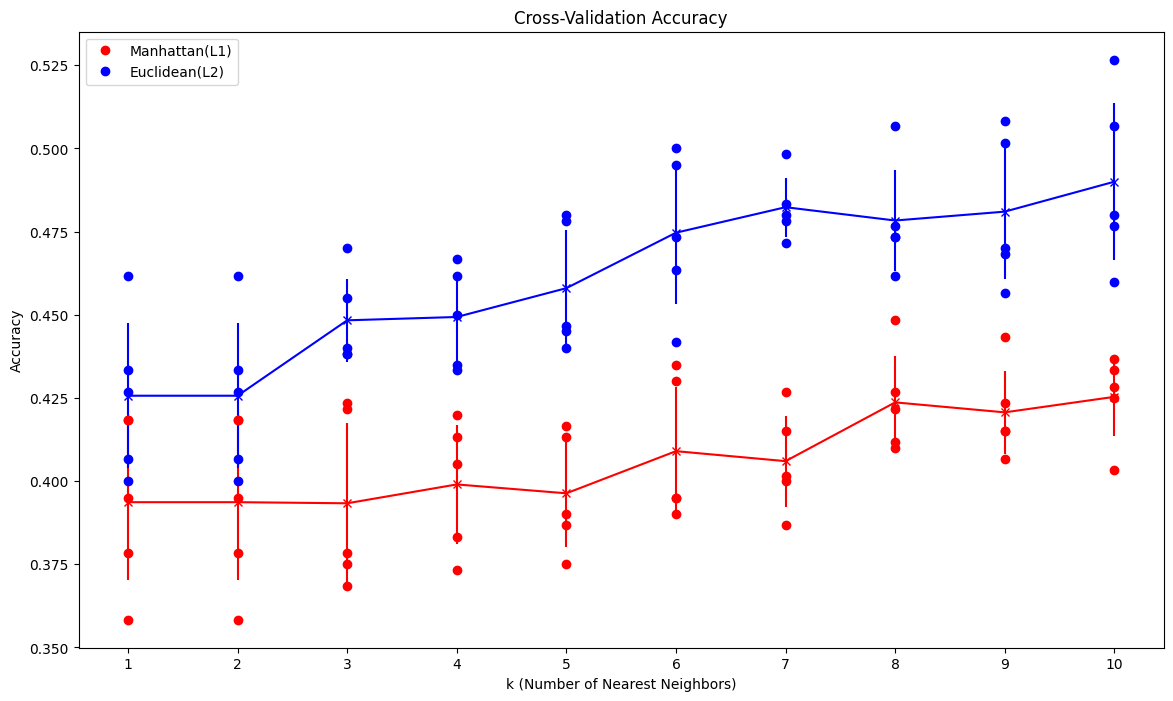

In [8]:
k_values = range(1, k_neighbours+1) #x-axis values
f_values = range(0, len(folds))

plt.figure(figsize=(14, 8))
plt.errorbar(k_values, mean_accuracy_l1, yerr=[np.std(accuracies_l1[k]) for k in k_values], marker='x', linestyle='-', color='r')
plt.errorbar(k_values, mean_accuracy_l2, yerr=[np.std(accuracies_l2[k]) for k in k_values], marker='x', linestyle='-', color='b')
for fold in f_values:
  plt.plot(k_values, [accuracies_l1[k][fold] for k in k_values], marker='o',linestyle='', color='r') # accuracies of each folds for each k values using l1
  plt.plot(k_values, [accuracies_l2[k][fold] for k in k_values], marker='o',linestyle='', color='b') # accuracies of each folds for each k values using l2
plt.title('Cross-Validation Accuracy')
plt.xlabel('k (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.legend(['Manhattan(L1)'] + ['Euclidean(L2)'])
plt.xticks(k_values)
plt.show()

# Discussion
**Comparison of Manhattan (L1) and Euclidean (L2) Distances** <br>
* The Euclidean (L2) distance metric consistently outperforms the
Manhattan (L1) distance metric across all k values.
* The average L2 distance line shows a positive trend, increases as    k-value increases

**Dataset's Characteristics** <br>
* Gray-scale images, where each pixel intensity represents a feature
* Higher resolution image have high-dimentinal feature space

**Feature Nature** <br>
* Pixel values can have high or low intensity due to light condition, noise, and other factors
* L1 distance is more robust to outliers and noise compared to L2 distance

**Class Complexity** <br>
* A clear distinction between the instances of classes can significantly improve both L1 and L2 performance

**Limitations and Improvements**
* Using raw pixel values is not the most effective representation
* Exploring a wider range of k-value can improve the performance
* Data preprocessing techniques like noise reduction, outlier extraction, high resolution image can imrove the performance



# Top 5 Predictions

In [9]:
def get_prediction(train_images, test_images, k_neighbours, distance_metric):
  predictions = []
  correct_pred = 0
  for test_img in tqdm.tqdm(test_images): #iterate through the test images
    distances = []

    for train_img in train_images:
      if np.array_equal(test_img[0], train_img[0]):
        continue
      elif distance_metric == 'l1':
        distances.append([np.sum(np.abs(test_img[0] - train_img[0])), train_img[1]])
      else:
        distances.append([np.sqrt(np.sum((test_img[0] - train_img[0]) ** 2)), train_img[1]])

    distances.sort(key=lambda x: x[0])
    n_neighbors = [distances[i] for i in range(k_neighbours)]

    label_counts = {}
    label_min_distances = {}

    for i in range(k_neighbours):
      label = n_neighbors[i][1]
      distance = n_neighbors[i][0]
      if label not in label_counts:
        label_counts[label] = 0
        label_min_distances[label] = float('Inf')
      label_counts[label] += 1
      label_min_distances[label] = min(label_min_distances[label], distance)

    max_count = max(label_counts.values())
    candidates = [label for label, count in label_counts.items() if count == max_count]
    pred_label = min(candidates, key=lambda label: label_min_distances[label])
    actual_label = test_img[1]
    if pred_label == actual_label:
      correct_pred += 1
    predictions.append(pred_label)

  accuracy = correct_pred / len(test_images)

  return predictions, accuracy

In [10]:
def display_predictions(test_images, predictions, num_to_display=5):
    labels = []
    for animal in os.listdir(test_dataset_path):
      labels.append(animal)
    plt.figure(figsize=(20, 10))
    for i in range(num_to_display):
        plt.subplot(num_to_display // 5, 5, i + 1)
        plt.imshow(test_images[i][0], cmap='gray')
        plt.title(f'Predicted: {labels[predictions[i]]}\nActual: {labels[test_images[i][1]]}')
        plt.axis('off')
    plt.show()
    print(f'Accuracy: {accuracy*100:.2f} %')

In [11]:
train_dataset_path = 'F:/OneDrive - American International University-Bangladesh/Semester-10/COMPUTER VISION AND PATTERN RECOGNITION/Assignment-1/dataset'
test_dataset_path = 'F:/OneDrive - American International University-Bangladesh/Semester-10/COMPUTER VISION AND PATTERN RECOGNITION/Assignment-1/test'
image_size = (256, 256)
k_neighbours = 5
distance_metric = 'l1'

train_images = get_images_and_labels(train_dataset_path, image_size)
test_images = get_images_and_labels(test_dataset_path, image_size)
predictions, accuracy = get_prediction(train_images, test_images, k_neighbours, 'l1')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.07it/s]


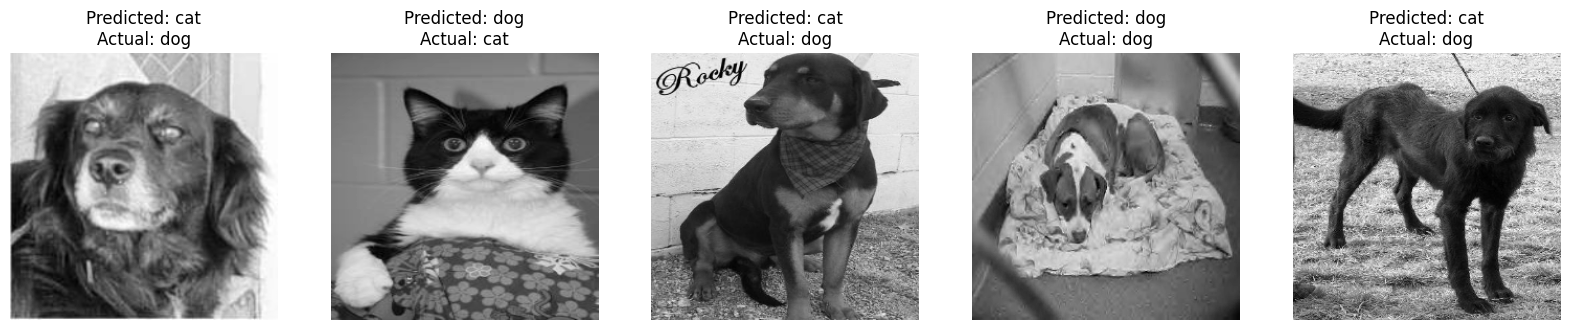

Accuracy: 36.67 %


In [12]:
display_predictions(test_images, predictions, num_to_display=5)